### Get IMG

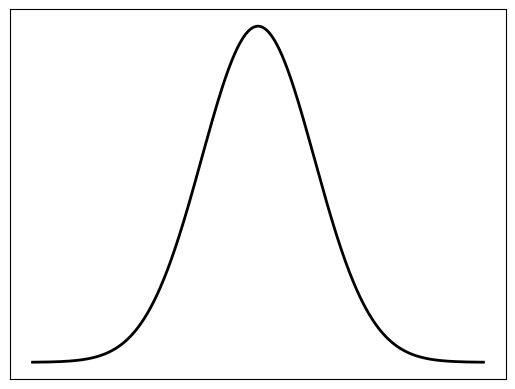

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Data for normal curve
x = np.linspace(-4, 4, 1000)
mean = 0
std_dev = 1
y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-((x - mean)**2) / (2 * std_dev**2))

# Plot
plt.plot(x, y, color='black', linewidth=2)

# Remove labels
plt.xticks([])
plt.yticks([])

plt.xlabel('')
plt.ylabel('')

# No grid
plt.grid(False)

# Show
plt.show()


### Data Preparation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.ticker as ticker

df = pd.read_csv('data/housing.csv')


In [4]:
# Extract necessary columns
df1 = df[['ocean_proximity', 'median_house_value']].copy()
df1.head()

,ocean_proximity,median_house_value
0,NEAR BAY,452600.0
1,NEAR BAY,358500.0
2,NEAR BAY,352100.0
3,NEAR BAY,341300.0
4,NEAR BAY,342200.0


In [5]:
# Keep only needed columns
df1 = df[['ocean_proximity', 'median_house_value']].copy()

# Map values
mapping = {
    '<1H OCEAN': 'coastal',
    'NEAR OCEAN': 'coastal',
    'NEAR BAY': 'coastal',
    'INLAND': 'inland'
}

# Apply mapping
df1['region'] = df1['ocean_proximity'].map(mapping)

# Drop rows with NaN (ISLAND)
df1 = df1.dropna(subset=['region'])

In [6]:
# Calculate IQR
Q1 = df1['median_house_value'].quantile(0.25)
Q3 = df1['median_house_value'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove Outliers
df1 = df1[(df1['median_house_value'] >= lower_bound) & 
          (df1['median_house_value'] <= upper_bound)]


### 1 sample t-test

In [7]:
# Overall mean of median_house_value in df1
overall_mean = df1['median_house_value'].mean()

# Coastal housing prices
coastal_prices = df1[df1['region'] == 'coastal']['median_house_value']

# One-sample t-test: test if coastal mean differs from overall mean
t_stat, p_value = stats.ttest_1samp(coastal_prices, overall_mean)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

T-statistic: 43.064
P-value: 0.000


In [31]:
overall_mean, coastal_prices.mean()

(190803.848701697, 224701.1575316213)

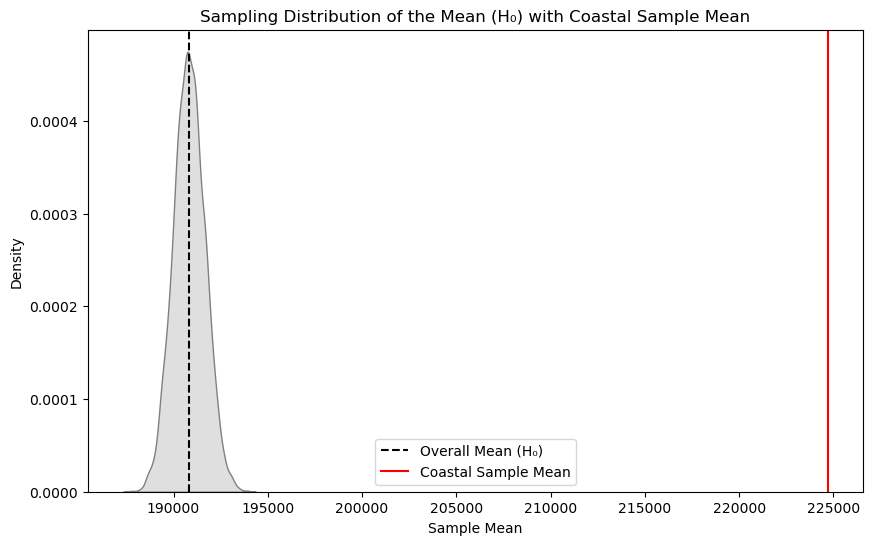

In [9]:
# Sample mean of coastal
coastal_mean = coastal_prices.mean()

# Bootstrap simulation to create sampling distribution of the mean under H0
np.random.seed(0)
bootstrap_means = []
for _ in range(10000):
    sample = np.random.choice(df1['median_house_value'], size=len(coastal_prices), replace=True)
    bootstrap_means.append(sample.mean())
bootstrap_means = np.array(bootstrap_means)

# Plot only the KDE curve with filled area (no histogram)
plt.figure(figsize=(10,6))
sns.kdeplot(bootstrap_means, fill=True, color='grey', linewidth=1)

# Add vertical lines for overall mean and coastal sample mean
plt.axvline(overall_mean, color='black', linestyle='--', label='Overall Mean (H₀)')
plt.axvline(coastal_mean, color='red', linestyle='-', label='Coastal Sample Mean')

# Labels and legend
plt.title('Sampling Distribution of the Mean (H₀) with Coastal Sample Mean')
plt.xlabel('Sample Mean')
plt.ylabel('Density')
plt.legend()
plt.show()


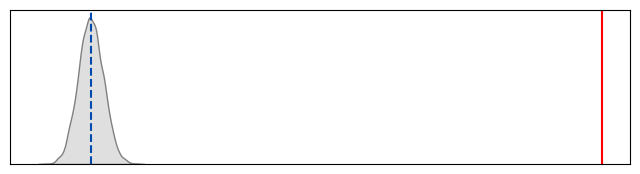

In [10]:
# Sample mean of coastal
coastal_mean = coastal_prices.mean()

# Bootstrap simulation to create sampling distribution of the mean under H0
np.random.seed(0)
bootstrap_means = []
for _ in range(10000):
    sample = np.random.choice(df1['median_house_value'], size=len(coastal_prices), replace=True)
    bootstrap_means.append(sample.mean())
bootstrap_means = np.array(bootstrap_means)

# Plot (only the KDE curve)
plt.figure(figsize=(8,2))
sns.kdeplot(bootstrap_means, fill=True, color='Grey', linewidth=1)

# Add vertical lines for overall mean and coastal sample mean
plt.axvline(overall_mean, color='#004aad', linestyle='--', label='Overall Mean (H₀)')
plt.axvline(coastal_mean, color='red', linestyle='-', label='Coastal Sample Mean')

# Labels and legend
plt.ylabel('')
plt.yticks([])  # Hide Y-axis numbers
plt.xticks([])

# Format X-axis ticks in 'k' (thousands)
formatter = ticker.FuncFormatter(lambda x, _: f'{int(x/1000)}k')
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()


### 2 Sample T-Test

In [11]:
# Get the two samples
coastal = df1[df1['region'] == 'coastal']['median_house_value']
inland = df1[df1['region'] == 'inland']['median_house_value']

# Perform the two-sample t-test
t_stat, p_value = stats.ttest_ind(coastal, inland, equal_var=False)  # Welch’s t-test recommended

# Output results
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")


T-statistic: 90.284
P-value: 0.000


In [12]:
coastal.mean() - inland.mean()

101728.3248885779

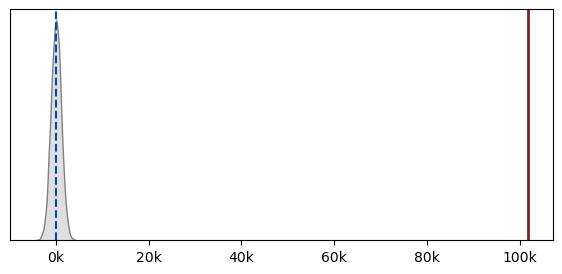

In [13]:
# Two groups
coastal = df1[df1['region'] == 'coastal']['median_house_value']
inland = df1[df1['region'] == 'inland']['median_house_value']

# Observed difference
observed_diff = coastal.mean() - inland.mean()

# Bootstrap sampling distribution of difference in means
np.random.seed(0)
bootstrap_diffs = []
for _ in range(10000):
    coastal_sample = np.random.choice(coastal, size=len(coastal), replace=True)
    inland_sample = np.random.choice(inland, size=len(inland), replace=True)
    diff = coastal_sample.mean() - inland_sample.mean()
    bootstrap_diffs.append(diff)
bootstrap_diffs = np.array(bootstrap_diffs)

# Shift bootstrap distribution to be centered at zero (null hypothesis)
null_dist = bootstrap_diffs - observed_diff

# Plot
plt.figure(figsize=(7, 3))
sns.kdeplot(null_dist, fill=True, color='grey', linewidth=1)

# Mark observed difference
plt.axvline(0, color='#004aad', linestyle='--', label='Null Hypothesis (0)')
plt.axvline(observed_diff, color='#7A2917', linestyle='-', linewidth=2, label='Observed Mean Difference')

# Format x-axis with 'k'
formatter = ticker.FuncFormatter(lambda x, _: f'{int(x/1000)}k')
plt.gca().xaxis.set_major_formatter(formatter)

# Label
plt.ylabel('')
plt.yticks([])

plt.show()
